# Codificador Automático

In [22]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, LSTM, Input, RepeatVector, TimeDistributed

In [2]:
def folder_to_sequence(folder_path: str, window_size: int) -> np.ndarray:
    """
    Função usada para converter os dados .csv de uma pasta
    para o formato aceito pelo autocodificador LSTM.

    Parameters
    ----------
    folder_path: str
        Caminho (pasta) em que os dados estão localizados.

    window_size: int
        Tamanho da janela de dados que o modelo receberá.

    Returns
    -------
    np.ndarray
        Array contendo as sequencias na forma de sequencias
    """

    X = None
    
    for filename in os.listdir("data/" + folder_path):
        if filename.endswith(".csv"):
            df_old = pd.read_csv("data/"+ folder_path + "/" + filename)
            df = calibrator.apply_calibration(df_old)
            sequences = df_to_sequence(df.PT105, window_size)
            if X is None:
                X = sequences
            else:
                X = np.concatenate((X, sequences))
    return X

def df_to_sequence(data: pd.DataFrame, window_size: int) -> np.ndarray:
    x = []
    for i in range(len(data) - window_size):
        row = [[r] for r in data[i:i+window_size]]  
        x.append(row)
        
    return np.array(x)

In [3]:
class Calibrator:
    def __init__(self):
        files = ["PT105"]
        self.data: dict = {}
        for filename in files:
            df = pd.read_csv(f"data/calibracao/{filename}.csv", delimiter=",", decimal=",")
            x, y = df.iloc[:, 0], df.iloc[:, 1]
            self.a, self.b = np.polyfit(x, y, 1)
            self.data[filename] = (self.a, self.b)
            
    def __str__(self) -> str:
        return str(self.data)

    def apply_calibration(self, df: pd.DataFrame) -> pd.DataFrame:
        df["PT105"] = self.a * df["cDAQ1Mod1/ai2"] + self.b
        return df

In [4]:
# ler a pasta
calibrator = Calibrator()

In [23]:
bigX = folder_to_sequence("VIDRO-B2", 100)
print("data shape: ", bigX.shape)

data shape:  (9070, 100, 1)


In [69]:
# teste 1
window_size = 100
autoencoder = Sequential(
    [
        Input((None, 1)), # Indica que os dados são unidimensionais
        
        LSTM(50, return_sequences=True),
        LSTM(20, return_sequences=False),
        RepeatVector(window_size),
        
        LSTM(20, return_sequences=True),
        LSTM(50, return_sequences=True),
        TimeDistributed(Dense(1))
    ]
)

In [70]:
autoencoder.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, None, 50)       │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 20)             │         5,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 100, 20)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 100, 20)        │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100, 50)        │        14,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 100, 1)         │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,611 (131.29 KB)

 Trainable params: 33,611 (131.29 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
autoencoder.compile(optimizer="adam", loss="mse")
history = autoencoder.fit(bigX, bigX, validation_split=0.3, epochs=5, batch_size=100, shuffle=True)

Epoch 1/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - loss: 0.8572 - val_loss: 0.0418
Epoch 2/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0533 - val_loss: 0.0197
Epoch 3/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0277 - val_loss: 0.0119
Epoch 4/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0172 - val_loss: 0.0092
Epoch 5/5
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.0107 - val_loss: 0.0056


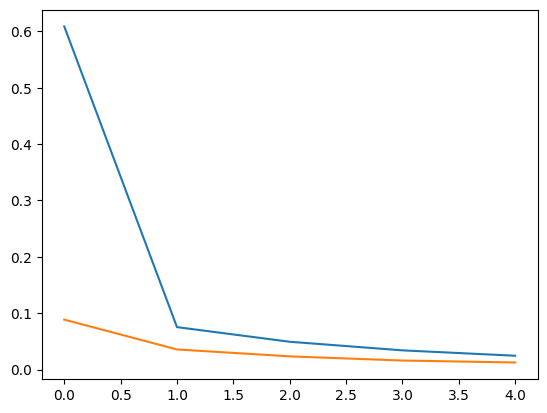

In [59]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [41]:
autoencoder.predict(bigX[0]).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


(10000,)

284/284 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step


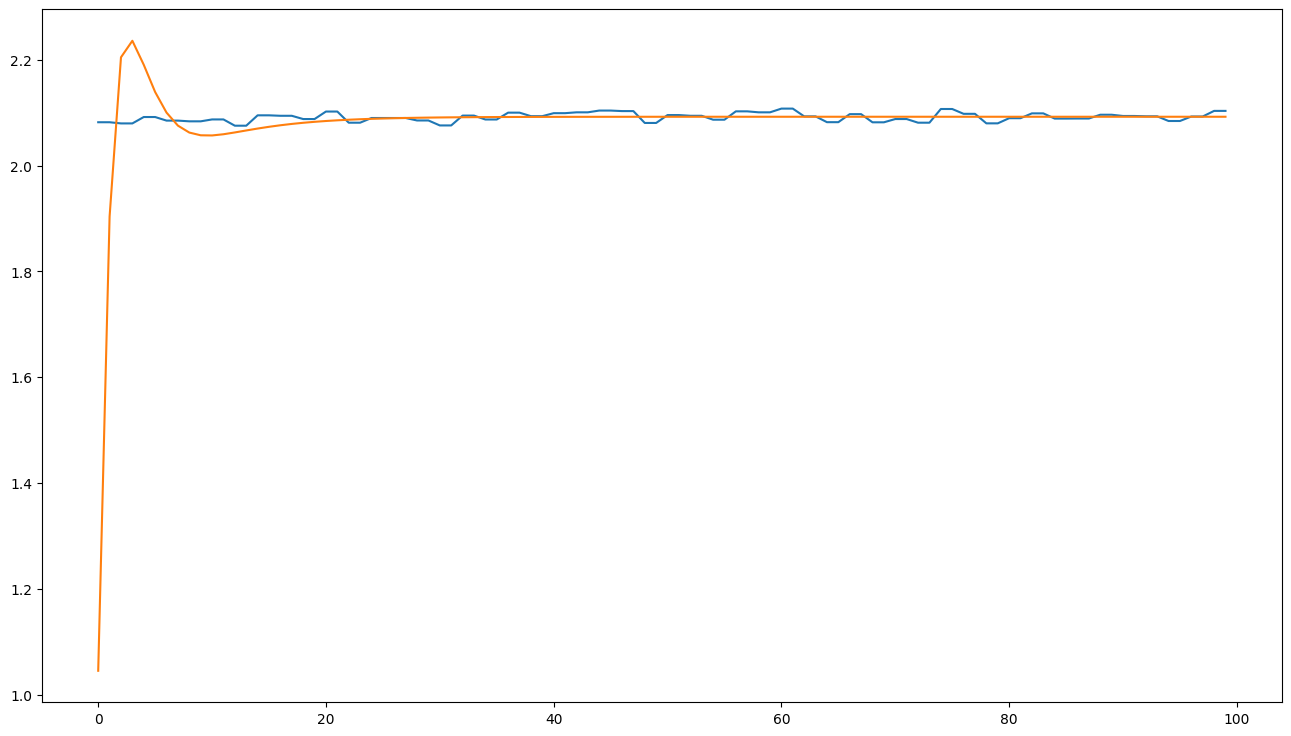

In [72]:
#predictions = autoencoder.predict(bigX)

plt.figure(figsize=(16,9))
plt.plot(bigX[5000])
plt.plot(predictions[5000])